# Phase II: Data Curation, Exploratory Analysis and Plotting (5\%)

### Team Members:
- Geon Chang
- Mukhilkanna Balakumar
- Khushal Shah


## Part 1:
(1%) Expresses the central motivation of the project and explains the (at least) two key questions to be explored. Gives a summary of the data processing pipeline so a technical expert can easily follow along.

## Problem Motivation

Financial market volatility presents both challenges and opportunities for investors. Predicting short-term S&P 500 movements can inform risk management and market timing strategies. This analysis examines whether simple technical indicators like momentum signals and volatility measures can forecast the next 5-day return of the S&P 500 index. Using historical price data and feature engineering, we aim to build an interpretable, data-driven prediction model.
Questions:

- Can short-term momentum and volatility features predict the S&P 500's next 5-day return?

- How does market regime (bullish vs. bearish) influence predictive power?

- What is the relative importance of each technical feature in predicting returns?

- Can machine learning models outperform a naive baseline that predicts zero return?


Motivating Sources:
- Efficient Market Hypothesis debates in academic finance literature


- Empirical evidence of short-term momentum and volatility anomalies in behavioral finance studies


## Summary of the Data Processing Pipeline

- Programmatically fetch S&P 500 daily prices from Stooq (free, no API key)

- Clean the data by validating dates, removing duplicates, and auto-detecting price columns

- Engineer features: calculate momentum (ret_5d, ret_20d), volatility (vol_20d), and moving average ratios (ma5_div_ma20)

- Define the target: compute 5-day forward return while avoiding look-ahead bias

- Save processed data as CSV for reproducibility


We acquire SPY (S&P 500 ETF) data from Stooq via direct CSV download with fallback URLs for robustness. After sorting by date and validating price data, we compute technical features using only past information available at time t. The target variable (target_5d_ret) looks 5 days ahead to maintain temporal separation. Rows with missing values from rolling windows (first 20 days) or the forward target (last 5 days) are dropped, resulting in over 5,000 clean trading days (2005–2025). The processed dataset is saved to ensure full reproducibility for subsequent modeling and analysis.

## Part 2:
(2\%) Obtains, cleans, and merges all data sources involved in the project.

In [1]:
# Importing Necessary Libraries
import pandas as pd
import numpy as np
import requests
from io import BytesIO
import os

In [2]:
# Function to clean the dataset
def clean_data(df):
    """
    Cleans and prepares the S&P 500 daily price dataset:
        - Converts the 'Date' column to datetime format
        - Sorts values chronologically
        - Detects and uses the appropriate price column (Close / Adj Close)
        - Handles missing or invalid values
        - Computes technical indicators (momentum & volatility)
        - Removes NaNs caused by rolling operations
        - Creates a target variable for the next-5-day return

    Args:
        df (pd.DataFrame): Raw price data

    Returns:
        df (pd.DataFrame): Cleaned and feature-engineered dataset
    """

    # Converting 'Date' column to datetime
    date_col = [c for c in df.columns if c.lower().startswith('date')]
    df['Date'] = pd.to_datetime(df[date_col[0]], errors='coerce')
    df.dropna(subset=['Date'], inplace=True)
    df.sort_values('Date', inplace=True)

    # Detecting valid price column (Close or Adj Close)
    price_candidates = ['Close', 'Adj Close', 'AdjClose', 'Price']
    price_col = next((c for c in price_candidates if c in df.columns), None)
    if not price_col:
        raise ValueError("No price column found.")

    # Removing invalid or zero prices
    df = df[df[price_col] > 0]

    # Creating features: 5-day and 20-day momentum & volatility
    df['ret_5d'] = df[price_col].pct_change(5)
    df['ret_20d'] = df[price_col].pct_change(20)
    df['vol_20d'] = df['ret_1d'] = df[price_col].pct_change(1)
    df['vol_20d'] = df['vol_20d'].rolling(20).std()

    # Moving-average ratio
    df['ma5_div_ma20'] = (
        df[price_col].rolling(5).mean() /
        df[price_col].rolling(20).mean()
    )

    # Target variable: 5-day forward return
    df['target_5d_ret'] = df[price_col].shift(-5) / df[price_col] - 1

    # Removing NaNs introduced by rolling operations
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df


In [3]:
# Primary data source: Stooq (SPY daily prices)
url_list = [
    "https://stooq.com/q/d/l/?s=spy.us&i=d",
    "https://stooq.com/q/d/l/?s=spy&i=d",
    "https://stooq.com/q/d/l/?s=%5Espx&i=d"
]

# Directory to save CSVs
if not os.path.exists('csv_files'):
    os.makedirs('csv_files')

merged_df = pd.DataFrame()
first_csv_path = None

# Downloading each candidate dataset
for i, url in enumerate(url_list):
    try:
        df_raw = pd.read_csv(url)
        print(f"Extracted data from {url} to DataFrame.")

        # Cleaning the dataset
        df_cleaned = clean_data(df_raw)

        # Saving cleaned CSV
        output_filename = f"csv_files/cleaned_{i+1}_sp500.csv"
        df_cleaned.to_csv(output_filename, index=False)
        print(f"Saved cleaned file → {output_filename}")

        # Merging into a unified dataset (deduplicate by Date)
        merged_df = pd.concat([merged_df, df_cleaned]).drop_duplicates(subset='Date')
        if first_csv_path is None:
            first_csv_path = output_filename

    except Exception as e:
        print(f"Error processing {url}: {e}")
        continue

# Checking and printing the first few rows of the merged dataset
if not merged_df.empty:
    merged_df.sort_values('Date', inplace=True)
    print("Successfully obtained, cleaned, and merged all S&P 500 data sources.")
    print(merged_df.head(10))
else:
    print("No dataset was successfully processed.")

print("\nDataset shape after merge:", merged_df.shape)
print("Columns:", merged_df.columns.tolist())


Extracted data from https://stooq.com/q/d/l/?s=spy.us&i=d to DataFrame.
Saved cleaned file → csv_files/cleaned_1_sp500.csv
Extracted data from https://stooq.com/q/d/l/?s=spy&i=d to DataFrame.
Error processing https://stooq.com/q/d/l/?s=spy&i=d: list index out of range
Extracted data from https://stooq.com/q/d/l/?s=%5Espx&i=d to DataFrame.
Saved cleaned file → csv_files/cleaned_3_sp500.csv
Successfully obtained, cleaned, and merged all S&P 500 data sources.
        Date  Open  High   Low  Close  Volume    ret_5d   ret_20d   vol_20d  \
0 1791-01-01  0.57  0.58  0.57   0.58     0.0  0.074074  0.137255  0.017862   
1 1791-02-01  0.58  0.59  0.58   0.59     0.0  0.072727  0.156863  0.017942   
2 1791-03-01  0.59  0.59  0.59   0.59     0.0  0.053571  0.180000  0.016890   
3 1791-04-01  0.60  0.60  0.60   0.60     0.0  0.090909  0.176471  0.016794   
4 1791-05-01  0.60  0.60  0.60   0.60     0.0  0.052632  0.176471  0.016794   
5 1791-06-01  0.60  0.60  0.60   0.60     0.0  0.034483  0.176471

## Part 3:
(2\%) Builds at least two visualizations (graphs/plots) from the data which help to understand or answer the questions of interest. These visualizations will be graded based on how much information they can effectively communicate to readers. Please make sure your visualization are sufficiently distinct from each other.

In [4]:
# importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

This is a reuse of code from the previous section, but instead of
saving the data to csv files, instead it compiles the data in a
dataframe with all of the data. The data must be compiled this way
because csvs do not preserve object type such as datetime.
The reason that this is a new code snippet is because compiling the
full dataframe in the previous snippet would remake all the csvs every time
the variables were reset.


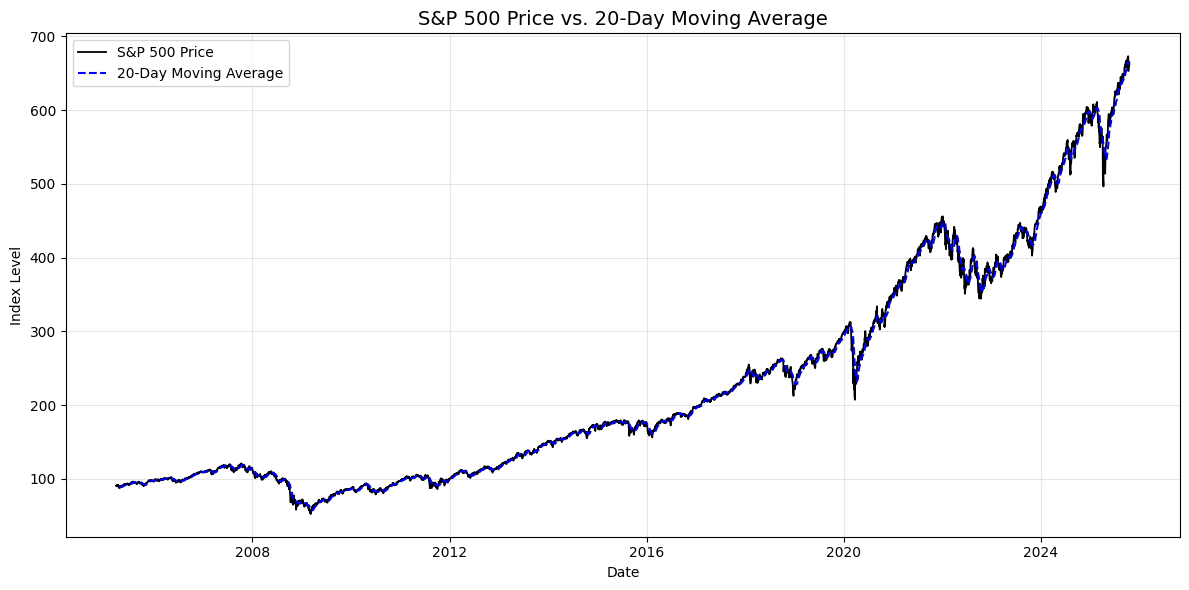

In [5]:
# specify the output CSV path explicitly
OUT_CSV = "csv_files/final_sp500_dataset.csv"

# if that file doesn't exist, fall back to the first cleaned file
import os
if not os.path.exists(OUT_CSV):
    OUT_CSV = "csv_files/cleaned_1_sp500.csv"

# load the dataset
df = pd.read_csv(OUT_CSV, parse_dates=['Date'])

# Visualization 1: Price with Moving Average Ratio (Trend view)
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='S&P 500 Price', color='black',
         linewidth=1.3)
plt.plot(df['Date'],
         df['Close'].rolling(20).mean(),
         label='20-Day Moving Average',
         color='blue',
         linestyle='--')

plt.title("S&P 500 Price vs. 20-Day Moving Average", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


This line chart displays the daily closing price of the S&P 500 alongside its 20-day moving average. The moving average smooths short-term fluctuations and highlights longer-term market trends. When the price line moves above the moving average, it often signals bullish momentum, while drops below it suggest bearish phases. This visualization helps readers quickly identify trend shifts, market cycles, and momentum crossovers, offering a clear picture of how the index behaved over time.

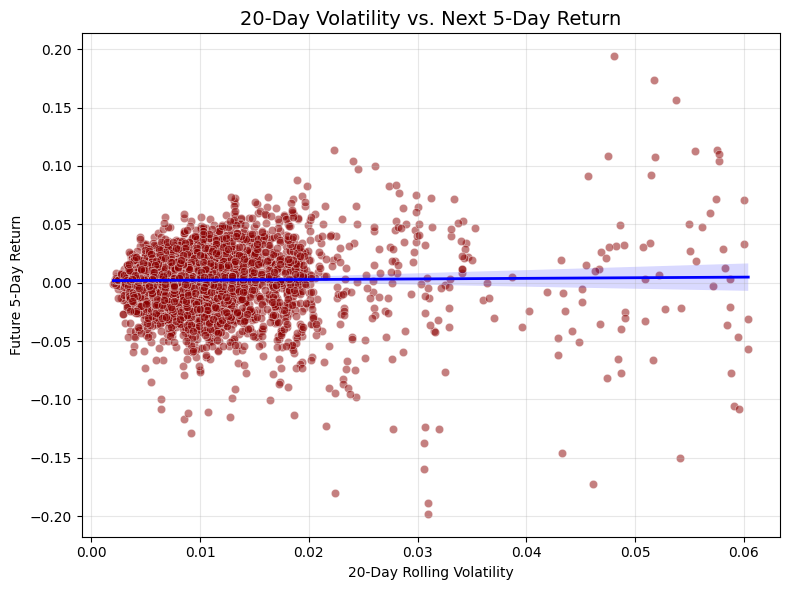

In [6]:
# Visualization 2: Relationship between Volatility & Future Returns
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='vol_20d',
    y='target_5d_ret',
    data=df,
    alpha=0.5,
    color='darkred'
)
sns.regplot(
    x='vol_20d',
    y='target_5d_ret',
    data=df,
    scatter=False,
    color='blue',
    line_kws={'linewidth':2}
)
plt.title("20-Day Volatility vs. Next 5-Day Return", fontsize=14)
plt.xlabel("20-Day Rolling Volatility")
plt.ylabel("Future 5-Day Return")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

This scatterplot explores the relationship between recent market volatility (20-day rolling standard deviation) and the S&P 500's future 5-day returns. Each point represents a trading day, with the blue regression line summarizing the overall trend.
The visualization reveals that higher volatility periods tend to correspond with lower or more unstable short-term returns, demonstrating the classic risk-return tradeoff in financial markets. It helps readers understand how recent uncertainty can impact upcoming performance.

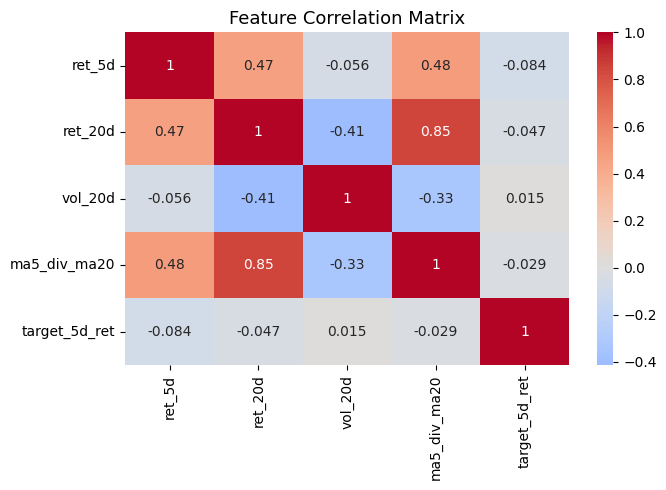

In [7]:
plt.figure(figsize=(7,5))
sns.heatmap(
    df[['ret_5d','ret_20d','vol_20d','ma5_div_ma20','target_5d_ret']].corr(),
    annot=True, cmap='coolwarm', center=0
)
plt.title("Feature Correlation Matrix", fontsize=13)
plt.tight_layout()
plt.show()

The heatmap visualizes correlations among key engineered features (momentum, volatility, moving-average ratio) and the target 5-day return. Warmer colors indicate strong positive relationships, while cooler tones show negative correlations. This chart provides a quick overview of how different financial indicators interact, helping identify which variables are most relevant for predicting short-term market behavior.